NTM setup:
This is a vanilla NTM implementation by LSTM controller with fixed input data stream.
The input table is a (p_size * n_addr) size 2d tensor with unordered input values, and the result table is the table with sorted vectors, the NTM will read both inputs and Memory in each timestep, and use the controller to learn how to sort and use it to sort the memory by the controller.


In [576]:
import numpy as np
import torch as tr

#setup
#number of addresses(size of w)
n_addr = 6
#LSTM pattern size(delay), or the number of different objects
p_size = 4
#LSTM hidden layer size
h_size = 64
#LSTM number of layers
n_layers = 1

#maximum number of iterators
num_ite = 2000

#input table
input_table = tr.zeros(p_size,n_addr)
input_table[0:4,0] = 1.
input_table[0,2] = 1.
input_table[0:2,0] = 1.
input_table[0:3,3] = 1.
input_table[0:4,1] = 1.
input_table[0,5] = 1.
#input_table = tr.rot90(input_table)

#result table
result_table = tr.zeros(p_size,n_addr)
result_table[0,0] = 1.
result_table[0,1] = 1.
result_table[0:2,2] = 1.
result_table[0:3,3] = 1.
result_table[0:4,4] = 1.
result_table[0:4,5] = 1.
#result_table = tr.rot90(result_table)

#initialize LSTM template
lstm = tr.nn.LSTM(
    input_size = p_size,
    hidden_size = h_size,
    num_layers = n_layers,
    batch_first = True)

#controller output template, also need to add to the parameter list
#initialize linear template for k_softmax 
k_out = tr.nn.Linear(h_size, p_size)
#initialize linear template for g_relu
g_out = tr.nn.Linear(h_size, 1)
#initialize linear template for s_softmax 
s_out = tr.nn.Linear(h_size, n_addr)
#initialize linear template fot y_sigmoid
y_out = tr.nn.Linear(h_size, 1)
#initialize linear template for result output
r_out = tr.nn.Linear(h_size, p_size)
#initialize linear template for beta_exp
b_out = tr.nn.Linear(h_size, 1)
#initialize linear template for erease_sigmoid
erease_out = tr.nn.Linear(h_size, p_size)
#initialize linear template for add_softmax
add_out = tr.nn.Linear(h_size, p_size)



#define M matrix
#define priority
alphanum = {# each element should have same size as p_size!
"z" : np.array([[ 0.0, 0.0, 0.0, 1.0]], dtype=np.float32).T,
    
"l" : np.array([[ 0.0, 0.0, 1.0, 1.0]], dtype=np.float32).T,

"i" : np.array([[ 0.0, 1.0, 1.0, 1.0]], dtype=np.float32).T,

"u" : np.array([[ 1.0, 1.0, 1.0, 1.0]], dtype=np.float32).T,
#"X" : np.array([[0,0,0,0]], dtype=np.float32).T
}
#generate activity patterns M, size = n_addr * p_size 
M = (tr.tensor(np.concatenate([alphanum[c].T for c in "ziuluz"]))).detach()


#w = tr.zeros(1,n_addr)
#w[0,0] = 1

#Content based
#initialize key k
#k =(tr.tensor(alphanum['i'],requires_grad = True))
#initialize B
#Beta = tr.tensor(1.0, requires_grad = True)
#initialize g
#g = tr.tensor(0.5, requires_grad = True)
#initialize w_n
#w_n = tr.zeros(1,n_addr, requires_grad = False)

#initialize s

#initialize y

In this model, I use the same gradient decent optimazion policy as we used in class.

In [523]:
#gradient decent optimization policy
def policy (loss, params, num_iters, learning_rate, verbose = 0):
    learning_curve = []#visualized the trainning result
    for i in range(num_iters):
        l = loss()
        if verbose > 0 and i%100 == 0:print(i, l.item())#print the training resut per 100 runs
        learning_curve.append(l.item())
        
        l.backward()
        for p in params:
            p.data -= learning_rate * p.grad #update p
            p.grad *= 0 #manually clean the gradient
        
    return learning_curve

This is the NTM body, the loss calculation, the memory addressing, super complex, weird bugs happened so many times. To be clear, I added so much comment to the code to make it as clear as possible.

In [565]:
#NTM read
def read (w, M):
    #dot product w.M
    #print(w)
    #print(M)
    return tr.mm(w,M)
#lstm loss
#NTM write


def lstm_loss():
    global M
    #hidden layer
    h = tr.zeros(n_layers,1,h_size)#same as hidden layer size
    c = tr.zeros(n_layers,1,h_size)#same as hidden layer size
    error = 0
    
    
    w_n = tr.randn(1,n_addr)


    
    #r = read(tr.zeros(1,n_addr),(M))
    r = read(w_n,M)

    for i in range(p_size):

        lstm_input = tr.zeros(1,p_size)

        lstm_input[0,0:p_size] = r
        lstm_input += input_table[:,i]

        #controller LSTM output
        lstm_out, (h,c) = lstm(lstm_input.reshape(1,1,(p_size)),(h,c))
        #print(lstm_out)

        
        #calculate w_c
        #value of K
        #k = tr.softmax(k_out(lstm_out), dim = 2).reshape(p_size,1)
        k = tr.softmax(k_out(lstm_out),dim = 2).reshape(p_size,1)
        #value of Beta
        Beta = tr.flatten(tr.exp(b_out(lstm_out)))
        #value of w_c
        w_c = content(M,k,Beta)
        #print("\nw_c")
        #print(w_c)
        

        #calulate w_g
        #value of g
        g = tr.flatten(tr.relu(g_out(lstm_out)))
        #value of w_g
        w_g = interpolate(g, w_n, w_c)
        #print("\nw_g")
        #print(w_g)

        #calculate w_
        #value of s
        s = tr.softmax(s_out(lstm_out), dim = 1).reshape(1,n_addr)
        w_ = shift(w_g, s)
        #print("\nw_")
        #print(w_)

        #calculate w_n
        #value of 
        y = tr.flatten(tr.sigmoid(y_out(lstm_out)))
        w_n = sharpen(w_, y)
        #print("\nw_n")
        #print(w_n)
        
        #write out
        #vector erease
        erease = tr.softmax(erease_out(lstm_out), dim = 2).reshape(1,p_size)
        #vector add
        add = tr.sigmoid(erease_out(lstm_out)).reshape(1,p_size)
        #update 
        #print(add)
        #print(w_n)
        #M = M - tr.mm(tr.rot90(w_n),erease) + tr.mm(tr.rot90(w_n),add)
        M = M.detach()
        M = M - tr.mm(tr.rot90(w_n).detach(),erease.detach()) + tr.mm(tr.rot90(w_n).detach(),add.detach())
        
        #print("\nM")
        #print(M)
        #value of output
        result = tr.relu(r_out(lstm_out)).reshape(1, p_size)
        #print(result)
        target = tr.zeros(1,1,p_size)
        target[0,0,:] = result_table[:,i]
        error += ((target-result)**2).sum()

        r = read(w_n, M)
    
    return error

The intresting fact that I didn't use the "address" function it self in my loss calculation, instead I use others step by step to get the w_new.

In [550]:
#adressing
def address(w, M, k, Beta, g, s, y):
    w_c = content(M, k, Beta)
    w_g = interpolate(g, w, w_c)
    w_ = shift(w_g, s)
    w_new = sharpen(w_, y)
    return w_new


def content(M, k, Beta):
    K = tr.mm(M, k) / ( tr.sum(M**2, dim=1)**.5 * tr.sum(k**2)**.5 ).reshape(-1,1)
    w_c = tr.softmax(Beta * K, dim=0).t()
    return w_c


def interpolate(g, w, w_c):
    return g*w_c + (1 - g)*w


def shift(w_g, s):
    N = s.shape[1]
    S = tr.cat([
        tr.index_select(s, dim=1, index=tr.tensor((np.arange(N)-j) % N))
        for j in range(N)])
    w_ = tr.sigmoid(tr.mm(w_g, S))
    return w_


def sharpen(w_, y):
    wy = w_**y
    return wy / wy.sum(dim=1)


The main function, show the result of the code.

torch.Size([6, 4])
tensor([[0., 0., 0., 1.],
        [0., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 1.]])
0 5.588285446166992
100 1.908894419670105
200 0.6109238862991333
300 1.2711268663406372
400 1.2793266773223877
500 1.2133409976959229
600 0.6142187118530273
700 0.5625455379486084
800 0.5269458293914795
900 1.1463377475738525
1000 1.1357929706573486
1100 0.46499574184417725
1200 1.0802853107452393
1300 0.4467592239379883
1400 0.44590306282043457
1500 0.6834264993667603
1600 1.0968042612075806
1700 1.0925016403198242
1800 2.6435835361480713
1900 3.0001678466796875
tensor([[315.3416, 320.7307, 337.6529, 338.1143],
        [315.3416, 321.7309, 338.6529, 338.1143],
        [316.3414, 321.7309, 338.6529, 338.1143],
        [315.3416, 320.7307, 338.6529, 338.1143],
        [316.3414, 321.7309, 338.6529, 338.1143],
        [315.3416, 320.7307, 337.6529, 338.1143]])


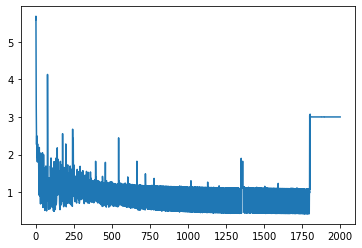

In [577]:
import matplotlib.pyplot as pt
if __name__ == "__main__":
    
    #test training
    print(M.size())
    print(M)
    params = list(lstm.parameters()) + list(r_out.parameters()) + list(k_out.parameters()) + list(b_out.parameters()) + list(g_out.parameters()) + list(s_out.parameters()) + list(y_out.parameters()) #+ list(erease_out.parameters()) + list(add_out.parameters())
    
    curve = policy(lstm_loss, params, num_ite, learning_rate=0.01, verbose = 1)
    print(M)
    pt.plot(curve)
    